# Ensemble & Random Forest

Será criado um modelo para predizer pessoas que devem procurar tratamento para saúde mental em empresas de tecnologia.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, auc, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("survey.csv")

> Dataset retirado do [kaggle](https://www.kaggle.com/osmi/mental-health-in-tech-survey/kernels), porém foram filtrados apenas os países Canada, United Kingdom e United States para facilitar a análise

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1008 non-null   object
 1   Age                        1008 non-null   int64 
 2   Gender                     1008 non-null   object
 3   Country                    1008 non-null   object
 4   state                      740 non-null    object
 5   self_employed              991 non-null    object
 6   family_history             1008 non-null   object
 7   treatment                  1008 non-null   object
 8   work_interfere             811 non-null    object
 9   no_employees               1008 non-null   object
 10  remote_work                1008 non-null   object
 11  tech_company               1008 non-null   object
 12  benefits                   1008 non-null   object
 13  care_options               1008 non-null   object
 14  wellness

In [4]:
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


Tratamento de variáveis:

In [5]:
# Timestamp:

del df['Timestamp']

### Variáveis com NaN:



In [6]:
# comments:
df.loc[df['comments'].notnull(), 'comments'].head()

12    I'm not on my company's health insurance which...
14    I have chronic low-level neurological issues t...
15    My company does provide healthcare but not to ...
22                  Relatively new job. Ask again later
23    Sometimes I think  about using drugs for my me...
Name: comments, dtype: object

Como o objetivo não é utilizar NLP, esta coluna será deletada

In [7]:
del df['comments']

work_interfere:

In [8]:
df['work_interfere'].value_counts()

Sometimes    389
Never        173
Rarely       139
Often        110
Name: work_interfere, dtype: int64

In [9]:
df['work_interfere'].fillna('DontKnow', inplace=True)

self_employed:

In [10]:
df['self_employed'].value_counts()

No     896
Yes     95
Name: self_employed, dtype: int64

In [11]:
df['self_employed'].fillna('No', inplace=True)

In [12]:
df['state'].value_counts()

CA    138
WA     70
NY     56
TN     45
TX     44
OH     30
PA     29
OR     29
IL     28
IN     27
MI     22
MN     21
MA     20
FL     15
NC     14
VA     14
GA     12
WI     12
MO     12
UT     10
CO      9
AL      8
AZ      7
MD      7
OK      6
NJ      6
KY      5
SC      5
DC      4
CT      4
IA      4
NV      3
VT      3
SD      3
KS      3
NH      3
WY      2
NM      2
NE      2
WV      1
ID      1
MS      1
RI      1
LA      1
ME      1
Name: state, dtype: int64

In [13]:
del df['state']

### Variaveis categoricas

Gender:

In [14]:
df['Gender'].unique()

array(['Female', 'M', 'Male', 'female', 'male', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'Cis Male', 'Woman', 'f',
       'Male (CIS)', 'queer/she/they', 'non-binary', 'Femake', 'woman',
       'Make', 'Nah', 'Enby', 'Genderqueer', 'Female ', 'Androgyne',
       'Agender', 'cis-female/femme', 'Guy (-ish) ^_^',
       'male leaning androgynous', 'Male ', 'Man', 'Trans woman', 'msle',
       'Neuter', 'Female (trans)', 'Female (cis)', 'Mail', 'cis male',
       'p', 'femail', 'Cis Man',
       'ostensibly male, unsure what that really means'], dtype=object)

Há muitas variáveis categóricas. Filtrando elas:

In [15]:
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^",  "neuter",  "queer", "ostensibly male, unsure what that really means"]           
female_str = ["trans-female", "cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail", "trans woman", "female (trans)"]

for (row, col) in df.iterrows():

    if str.lower(col.Gender) in male_str:
        df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        df['Gender'].replace(to_replace=col.Gender, value='other', inplace=True)

In [16]:
df['Gender'].value_counts()

male      772
female    224
other      11
p           1
Name: Gender, dtype: int64

In [17]:
df = df[df['Gender']!='p']

In [18]:
df['Gender'].unique()

array(['female', 'male', 'other'], dtype=object)

Vendo quantos países há na base da dados:

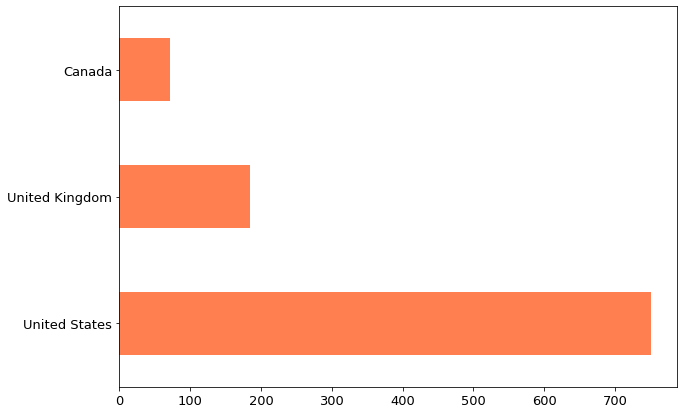

In [19]:
df['Country'].value_counts().plot(kind='barh', figsize=(10,7),
                                        color="coral", fontsize=13);

Vamos fazer o processo de one-hot enconding utilizando a função get_dummies do pandas. Ele transforma cada valor da coluna em uma nova coluna binária, exemplo:

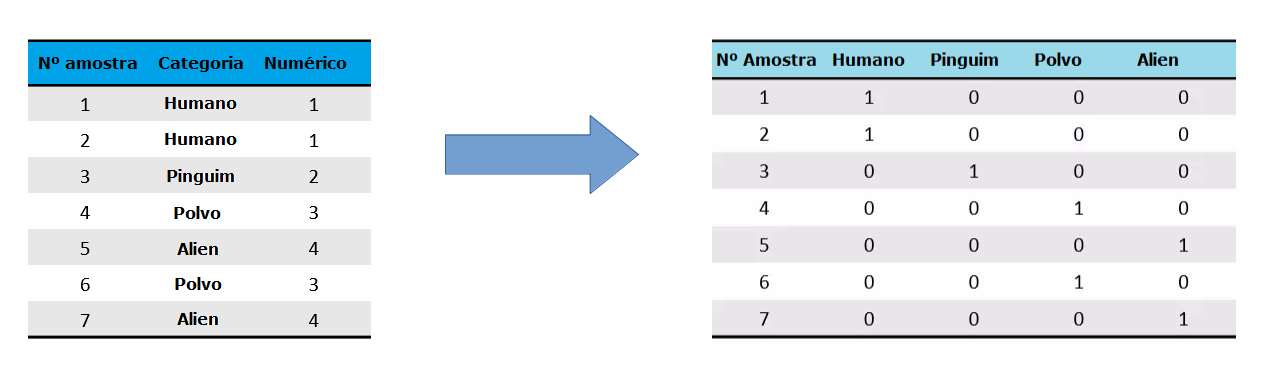

In [20]:
df = pd.get_dummies(df, columns=['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help'])

In [21]:
df.shape

(1007, 71)

In [22]:
df.columns.values

array(['Age', 'Gender_female', 'Gender_male', 'Gender_other',
       'Country_Canada', 'Country_United Kingdom',
       'Country_United States', 'self_employed_No', 'self_employed_Yes',
       'family_history_No', 'family_history_Yes', 'treatment_No',
       'treatment_Yes', 'work_interfere_DontKnow', 'work_interfere_Never',
       'work_interfere_Often', 'work_interfere_Rarely',
       'work_interfere_Sometimes', 'no_employees_1-5',
       'no_employees_100-500', 'no_employees_26-100',
       'no_employees_500-1000', 'no_employees_6-25',
       'no_employees_More than 1000', 'remote_work_No', 'remote_work_Yes',
       'tech_company_No', 'tech_company_Yes', "anonymity_Don't know",
       'anonymity_No', 'anonymity_Yes', "leave_Don't know",
       'leave_Somewhat difficult', 'leave_Somewhat easy',
       'leave_Very difficult', 'leave_Very easy',
       'mental_health_consequence_Maybe', 'mental_health_consequence_No',
       'mental_health_consequence_Yes', 'phys_health_consequence_May

In [23]:
df.drop(columns=['family_history_No', 'treatment_No', 'remote_work_No', 'tech_company_No'], inplace=True)

Olhando a distribuição da variável resposta:

<AxesSubplot:>

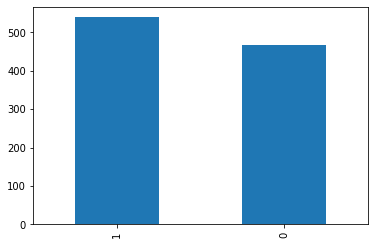

In [24]:
df['treatment_Yes'].value_counts().plot(kind='bar')

## Treinamento

Separando os dados em treino e teste:

In [25]:
X = df.drop('treatment_Yes', axis=1)
y = df['treatment_Yes']

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.15, random_state=0)
print(X_train.shape)

(855, 66)


## Árvore de decisão

In [26]:
# Utilizando Decision Tree com random state igual a 10

model_tree = DecisionTreeClassifier(random_state=10)
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=10)

In [27]:
y_pred_tree_train = model_tree.predict_proba(X_train)
print("Acurácia: {:.2f}".format(accuracy_score(y_train, y_pred_tree_train[:,1]>0.5)))
print("Precisão: {:.2f}".format(precision_score(y_train, y_pred_tree_train[:,1]>0.5)))
print("Sensibilidade: {:.2f}".format(recall_score(y_train, y_pred_tree_train[:,1]>0.5)))

Acurácia: 1.00
Precisão: 1.00
Sensibilidade: 1.00


In [28]:
y_pred_tree = model_tree.predict_proba(X_test)
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred_tree[:,1]>0.5)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred_tree[:,1]>0.5)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred_tree[:,1]>0.5)))

Acurácia: 0.82
Precisão: 0.84
Sensibilidade: 0.82


## KNN 

In [29]:
# Criando um modelo KNN com random state igual a 10

model_knn = KNeighborsClassifier()
model_knn.fit(X_train,y_train)

KNeighborsClassifier()

In [30]:
y_pred_knn_train = model_knn.predict_proba(X_train)
print("Acurácia: {:.2f}".format(accuracy_score(y_train, y_pred_knn_train[:,1]>0.5)))
print("Precisão: {:.2f}".format(precision_score(y_train, y_pred_knn_train[:,1]>0.5)))
print("Sensibilidade: {:.2f}".format(recall_score(y_train, y_pred_knn_train[:,1]>0.5)))

Acurácia: 0.78
Precisão: 0.81
Sensibilidade: 0.78


In [31]:
y_pred_knn = model_knn.predict_proba(X_test)
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred_knn[:,1]>0.5)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred_knn[:,1]>0.5)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred_knn[:,1]>0.5)))

Acurácia: 0.70
Precisão: 0.73
Sensibilidade: 0.71


### Como combinar esses modelos?

- Fazendo votação das predições
- Fazendo média das predições
- Usando as predições como entrada para uma segunda camada de modelos

In [32]:
model_vot = VotingClassifier(estimators=[('tree', model_tree), ('knn', model_knn)], voting='soft')
model_vot.fit(X_train, y_train)                             

VotingClassifier(estimators=[('tree', DecisionTreeClassifier(random_state=10)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')

In [33]:
y_pred = model_vot.predict(X_test)
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

Acurácia: 0.82
Precisão: 0.85
Sensibilidade: 0.82


In [34]:
#Exemplo Stacking
x_novo = np.array([y_pred_tree_train[:,1], y_pred_knn_train[:,1]])
x_novo = x_novo.transpose()

x_novo_test = np.array([y_pred_tree[:,1], y_pred_knn[:,1]])
x_novo_test = x_novo_test.transpose()

In [35]:
model_lr2 = LogisticRegression()
model_lr2.fit(x_novo, y_train)

LogisticRegression()

In [36]:
y_pred_lr = model_lr2.predict_proba(x_novo_test)
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred_lr[:,1]>0.5)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred_lr[:,1]>0.5)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred_lr[:,1]>0.5)))

Acurácia: 0.82
Precisão: 0.84
Sensibilidade: 0.82


In [37]:
# Testando com o Random Forest

model = RandomForestClassifier(n_estimators=10, random_state=0, oob_score=True)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, oob_score=True, random_state=0)

In [38]:
model.oob_score_

0.7403508771929824

In [39]:
y_pred = model.predict(X_test)
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

Acurácia: 0.80
Precisão: 0.84
Sensibilidade: 0.78


Testando outras combinações de parâmetros?

- Dica 1: Manter o mesmo random_state para comparação de resultados

- Dica 2: Os parâmetros são similares as árvores de decisão
 
- Dica 3: Número de estimadores e de features são os mais relevantes ` 

In [40]:
model = RandomForestClassifier(n_estimators=20, random_state=0, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("OOB Score: {:.2f}".format(model.oob_score_))
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

# essa função calcula a curva roc e retorna a taxa de true positive, false positive e os thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

print('AUC: ' + str(auc(fpr, tpr)))

OOB Score: 0.78
Acurácia: 0.87
Precisão: 0.86
Sensibilidade: 0.90
AUC: 0.9270123974157499


In [41]:
model = RandomForestClassifier(n_estimators=40, random_state=0, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("OOB Score: {:.2f}".format(model.oob_score_))
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

# essa função calcula a curva roc e retorna a taxa de true positive, false positive e os thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

print('AUC: ' + str(auc(fpr, tpr)))

OOB Score: 0.80
Acurácia: 0.86
Precisão: 0.85
Sensibilidade: 0.90
AUC: 0.9325126593329841


In [42]:
model = RandomForestClassifier(n_estimators=50, random_state=0, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("OOB Score: {:.2f}".format(model.oob_score_))
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

# essa função calcula a curva roc e retorna a taxa de true positive, false positive e os thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

print('AUC: ' + str(auc(fpr, tpr)))

OOB Score: 0.81
Acurácia: 0.88
Precisão: 0.86
Sensibilidade: 0.92
AUC: 0.9312903789069321


In [43]:
model = RandomForestClassifier(n_estimators=50, random_state=0, oob_score=True, max_features=7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("OOB Score: {:.2f}".format(model.oob_score_))
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

# essa função calcula a curva roc e retorna a taxa de true positive, false positive e os thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

print('AUC: ' + str(auc(fpr, tpr)))

OOB Score: 0.81
Acurácia: 0.93
Precisão: 0.91
Sensibilidade: 0.96
AUC: 0.9314649903963681


Feature importance:

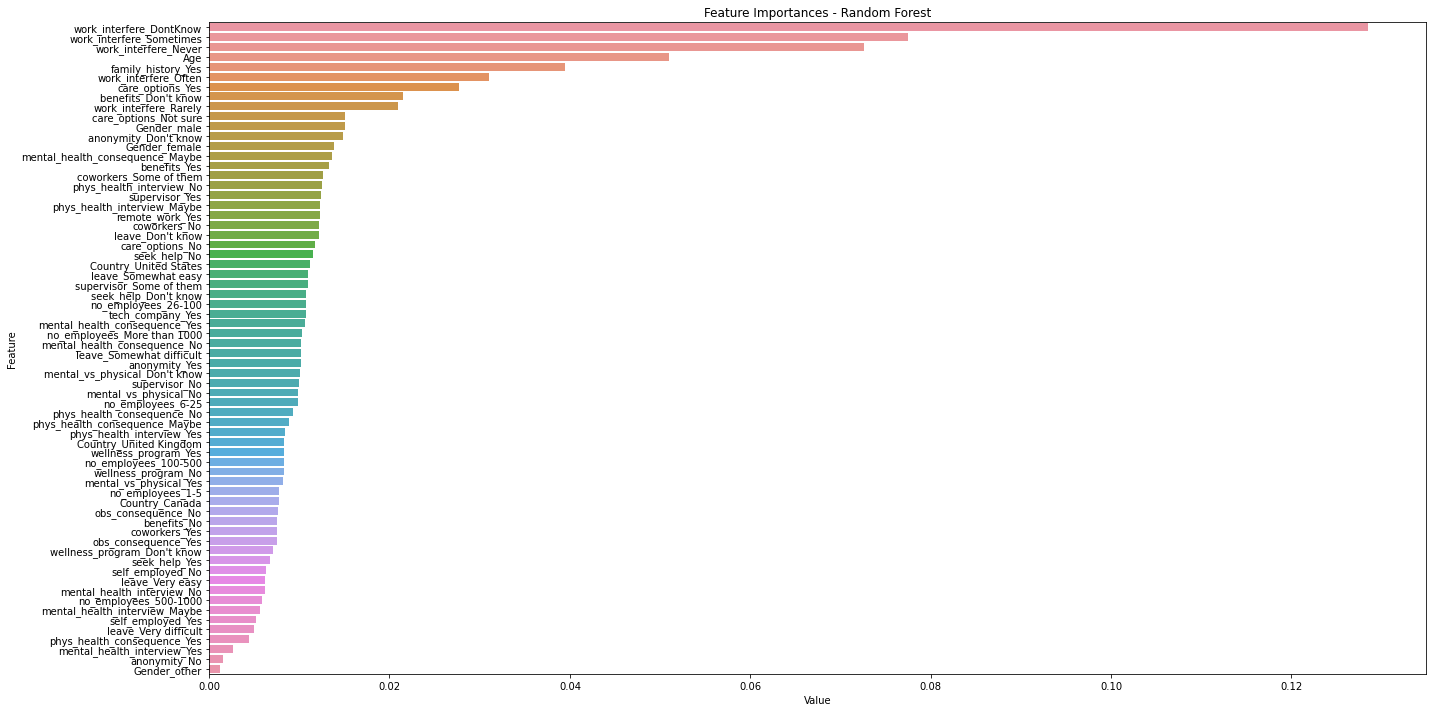

<Figure size 432x288 with 0 Axes>

In [44]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature Importances - Random Forest')
plt.tight_layout()
plt.show()
plt.savefig('rf_importances-01.png')

### **Comparando as variáveis mais correlacionadas com a variável resposta VS as variáveis mais importantes de acordo com a Random Forest**

<AxesSubplot:>

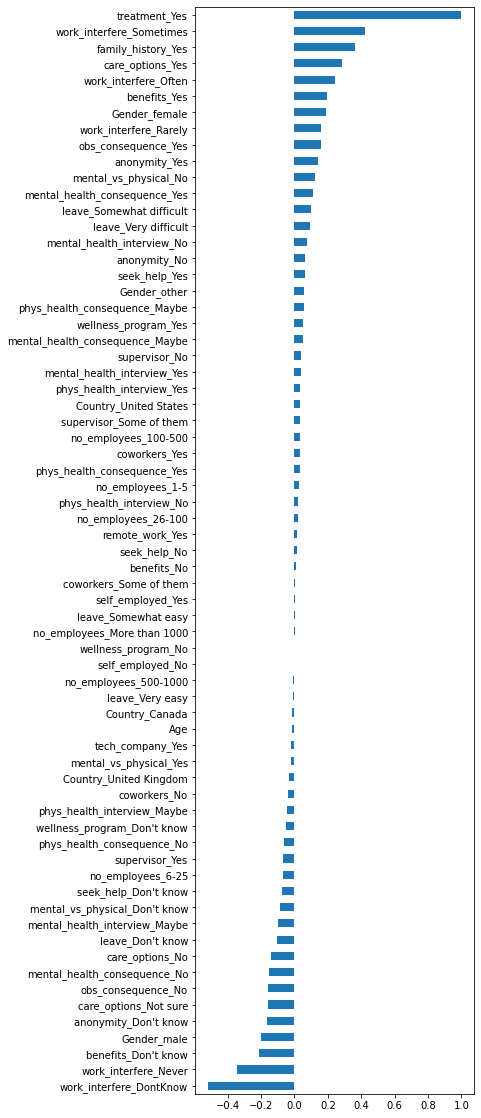

In [45]:
corr_matrix = df.corr()
plt.figure(figsize=(5,20))
corr_matrix['treatment_Yes'].sort_values(ascending=True).plot(kind='barh')

In [46]:
corr_matrix['treatment_Yes'].abs().sort_values()[0:3].index

Index(['no_employees_More than 1000', 'leave_Somewhat easy',
       'wellness_program_No'],
      dtype='object')

In [47]:
Xtrain_menos3 = X_train.drop(columns=corr_matrix['treatment_Yes'].abs().sort_values()[0:3].index)
Xtest_menos3 = X_test.drop(columns=corr_matrix['treatment_Yes'].abs().sort_values()[0:3].index)

In [48]:
model = RandomForestClassifier(n_estimators=50, random_state=0, oob_score=True, max_features=7)
model.fit(Xtrain_menos3, y_train)
y_pred = model.predict(Xtest_menos3)
y_pred_proba = model.predict_proba(Xtest_menos3)

print("OOB Score: {:.2f}".format(model.oob_score_))
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

# essa função calcula a curva roc e retorna a taxa de true positive, false positive e os thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

print('AUC: ' + str(auc(fpr, tpr)))

OOB Score: 0.82
Acurácia: 0.93
Precisão: 0.90
Sensibilidade: 0.98
AUC: 0.9325999650777022


## Light GBM 

In [49]:
import lightgbm as lgb

In [50]:
model = lgb.LGBMClassifier(objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          learning_rate=0.1,
          n_estimators=50,
          max_features=7,
          num_leaves= 8)


In [51]:
model.fit(Xtrain_menos3, y_train)


[LightGBM] [Warning] Unknown parameter: max_features


LGBMClassifier(max_features=7, n_estimators=50, n_jobs=3, num_leaves=8,
               objective='binary')

In [52]:
y_pred_train = model.predict(Xtrain_menos3)
print("Acurácia: {:.2f}".format(accuracy_score(y_train, y_pred_train)))
print("Precisão: {:.2f}".format(precision_score(y_train, y_pred_train)))
print("Sensibilidade: {:.2f}".format(recall_score(y_train, y_pred_train)))

Acurácia: 0.87
Precisão: 0.85
Sensibilidade: 0.93


In [53]:
y_pred = model.predict(Xtest_menos3)

y_pred_proba = model.predict_proba(Xtest_menos3)

print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

# essa função calcula a curva roc e retorna a taxa de true positive, false positive e os thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

print('AUC: ' + str(auc(fpr, tpr)))

Acurácia: 0.91
Precisão: 0.88
Sensibilidade: 0.96
AUC: 0.9209009952854899


Vendo o que acontece quando o número de folhas é retirado

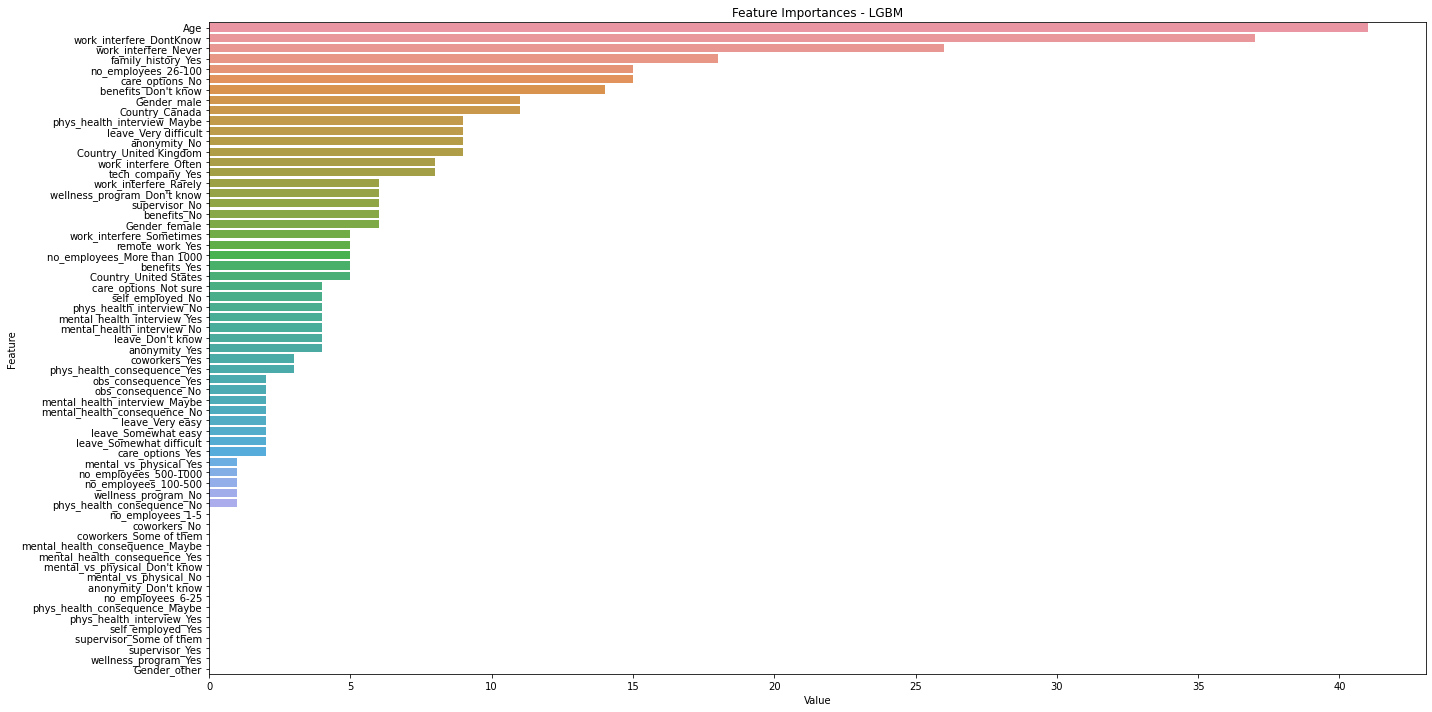

<Figure size 432x288 with 0 Axes>

In [54]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature Importances - LGBM')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

### Mudando parâmetros para o modelo

In [55]:
model = lgb.LGBMClassifier(objective = 'binary',
          n_jobs = 3,
          learning_rate=0.2,
          n_estimators=50,
          max_features=7,
          num_leaves=15)

In [56]:
model.fit(Xtrain_menos3, y_train)

[LightGBM] [Warning] Unknown parameter: max_features


LGBMClassifier(learning_rate=0.2, max_features=7, n_estimators=50, n_jobs=3,
               num_leaves=15, objective='binary')

In [57]:
y_pred_train = model.predict(Xtrain_menos3)
print("Acurácia: {:.2f}".format(accuracy_score(y_train, y_pred_train)))
print("Precisão: {:.2f}".format(precision_score(y_train, y_pred_train)))
print("Sensibilidade: {:.2f}".format(recall_score(y_train, y_pred_train)))

Acurácia: 0.98
Precisão: 0.98
Sensibilidade: 0.99


In [58]:
y_pred = model.predict(Xtest_menos3)

y_pred_proba = model.predict_proba(Xtest_menos3)

In [59]:
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

print('AUC: ' + str(auc(fpr, tpr)))

Acurácia: 0.88
Precisão: 0.87
Sensibilidade: 0.90
AUC: 0.9151388161341016
